# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:15<00:00, 3.83KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

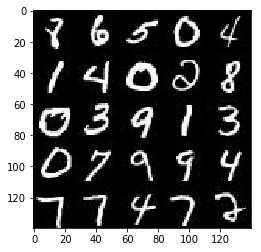

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

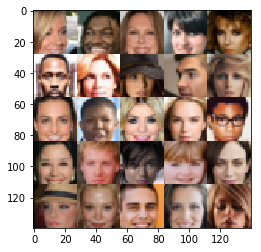

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/DruidKuma/miniconda3/envs/dog-project/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [26]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    step = 1
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                
                if step % 10 == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}.\t".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}; ".format(d_loss_train),
                          "Generator Loss: {:.4f}".format(g_loss_train))
                
                if step % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2.	 Discriminator Loss: 0.1875;  Generator Loss: 7.4949
Epoch 1/2.	 Discriminator Loss: 0.3459;  Generator Loss: 4.2665
Epoch 1/2.	 Discriminator Loss: 1.0640;  Generator Loss: 2.2120
Epoch 1/2.	 Discriminator Loss: 0.1849;  Generator Loss: 3.9137
Epoch 1/2.	 Discriminator Loss: 3.0110;  Generator Loss: 7.8287
Epoch 1/2.	 Discriminator Loss: 6.6667;  Generator Loss: 0.0071
Epoch 1/2.	 Discriminator Loss: 4.0585;  Generator Loss: 0.0519
Epoch 1/2.	 Discriminator Loss: 1.7693;  Generator Loss: 0.3427
Epoch 1/2.	 Discriminator Loss: 1.9199;  Generator Loss: 0.7691
Epoch 1/2.	 Discriminator Loss: 1.7029;  Generator Loss: 0.4725


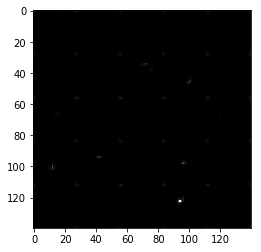

Epoch 1/2.	 Discriminator Loss: 1.9262;  Generator Loss: 0.5020
Epoch 1/2.	 Discriminator Loss: 1.5192;  Generator Loss: 0.3966
Epoch 1/2.	 Discriminator Loss: 1.4610;  Generator Loss: 2.2354
Epoch 1/2.	 Discriminator Loss: 1.3273;  Generator Loss: 0.8994
Epoch 1/2.	 Discriminator Loss: 2.3119;  Generator Loss: 3.1747
Epoch 1/2.	 Discriminator Loss: 1.8094;  Generator Loss: 0.2867
Epoch 1/2.	 Discriminator Loss: 1.3675;  Generator Loss: 2.5245
Epoch 1/2.	 Discriminator Loss: 1.0361;  Generator Loss: 0.9327
Epoch 1/2.	 Discriminator Loss: 2.7032;  Generator Loss: 3.8442
Epoch 1/2.	 Discriminator Loss: 2.0848;  Generator Loss: 0.2473


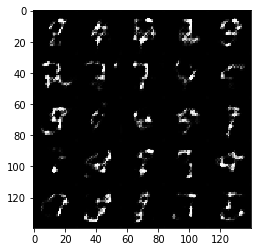

Epoch 1/2.	 Discriminator Loss: 2.1555;  Generator Loss: 0.2249
Epoch 1/2.	 Discriminator Loss: 1.4262;  Generator Loss: 0.8097
Epoch 1/2.	 Discriminator Loss: 1.8797;  Generator Loss: 0.3587
Epoch 1/2.	 Discriminator Loss: 1.8875;  Generator Loss: 0.3272
Epoch 1/2.	 Discriminator Loss: 1.1677;  Generator Loss: 1.4406
Epoch 1/2.	 Discriminator Loss: 1.7956;  Generator Loss: 2.4511
Epoch 1/2.	 Discriminator Loss: 1.5670;  Generator Loss: 0.4152
Epoch 1/2.	 Discriminator Loss: 1.3470;  Generator Loss: 1.1697
Epoch 1/2.	 Discriminator Loss: 0.8489;  Generator Loss: 1.1799
Epoch 1/2.	 Discriminator Loss: 1.2262;  Generator Loss: 0.7298


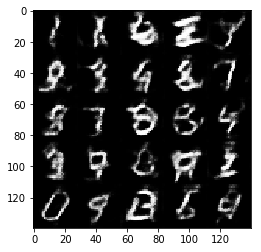

Epoch 1/2.	 Discriminator Loss: 1.1740;  Generator Loss: 0.7467
Epoch 1/2.	 Discriminator Loss: 1.2560;  Generator Loss: 1.2317
Epoch 1/2.	 Discriminator Loss: 1.4952;  Generator Loss: 0.4479
Epoch 1/2.	 Discriminator Loss: 1.4081;  Generator Loss: 0.5021
Epoch 1/2.	 Discriminator Loss: 1.1188;  Generator Loss: 0.8004
Epoch 1/2.	 Discriminator Loss: 1.5088;  Generator Loss: 0.4679
Epoch 1/2.	 Discriminator Loss: 1.2772;  Generator Loss: 0.5910
Epoch 1/2.	 Discriminator Loss: 1.2853;  Generator Loss: 1.1698
Epoch 1/2.	 Discriminator Loss: 1.1058;  Generator Loss: 0.7739
Epoch 1/2.	 Discriminator Loss: 1.2034;  Generator Loss: 0.6883


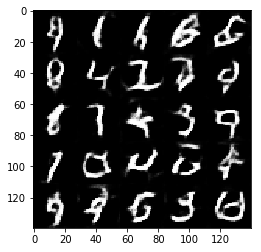

Epoch 1/2.	 Discriminator Loss: 1.2210;  Generator Loss: 1.1158
Epoch 1/2.	 Discriminator Loss: 1.3298;  Generator Loss: 0.5027
Epoch 1/2.	 Discriminator Loss: 1.3337;  Generator Loss: 0.4672
Epoch 1/2.	 Discriminator Loss: 1.2971;  Generator Loss: 0.5511
Epoch 1/2.	 Discriminator Loss: 1.0870;  Generator Loss: 1.2721
Epoch 1/2.	 Discriminator Loss: 1.3293;  Generator Loss: 0.5462
Epoch 1/2.	 Discriminator Loss: 1.4031;  Generator Loss: 1.8276
Epoch 1/2.	 Discriminator Loss: 1.2270;  Generator Loss: 0.5728
Epoch 1/2.	 Discriminator Loss: 1.1694;  Generator Loss: 0.7012
Epoch 1/2.	 Discriminator Loss: 1.2223;  Generator Loss: 1.0442


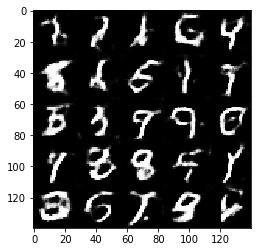

Epoch 1/2.	 Discriminator Loss: 1.3919;  Generator Loss: 0.5651
Epoch 1/2.	 Discriminator Loss: 1.1991;  Generator Loss: 0.6050
Epoch 1/2.	 Discriminator Loss: 1.4021;  Generator Loss: 1.7399
Epoch 1/2.	 Discriminator Loss: 1.2133;  Generator Loss: 1.1242
Epoch 1/2.	 Discriminator Loss: 1.4849;  Generator Loss: 2.3053
Epoch 1/2.	 Discriminator Loss: 1.2426;  Generator Loss: 0.8404
Epoch 1/2.	 Discriminator Loss: 1.2820;  Generator Loss: 1.0319
Epoch 1/2.	 Discriminator Loss: 1.0563;  Generator Loss: 1.0227
Epoch 1/2.	 Discriminator Loss: 1.4041;  Generator Loss: 1.5435
Epoch 1/2.	 Discriminator Loss: 1.3011;  Generator Loss: 1.3456


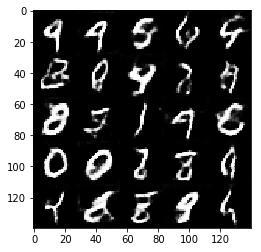

Epoch 1/2.	 Discriminator Loss: 1.3484;  Generator Loss: 0.5724
Epoch 1/2.	 Discriminator Loss: 1.2701;  Generator Loss: 0.5022
Epoch 1/2.	 Discriminator Loss: 1.3988;  Generator Loss: 0.5453
Epoch 1/2.	 Discriminator Loss: 1.2368;  Generator Loss: 1.4521
Epoch 1/2.	 Discriminator Loss: 1.2170;  Generator Loss: 1.3984
Epoch 1/2.	 Discriminator Loss: 1.4912;  Generator Loss: 0.4004
Epoch 1/2.	 Discriminator Loss: 1.0547;  Generator Loss: 1.0780
Epoch 1/2.	 Discriminator Loss: 1.2478;  Generator Loss: 0.6800
Epoch 1/2.	 Discriminator Loss: 1.2112;  Generator Loss: 1.3931
Epoch 1/2.	 Discriminator Loss: 1.3313;  Generator Loss: 1.0825


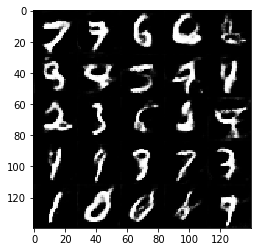

Epoch 1/2.	 Discriminator Loss: 1.0427;  Generator Loss: 0.9706
Epoch 1/2.	 Discriminator Loss: 1.5909;  Generator Loss: 0.3221
Epoch 1/2.	 Discriminator Loss: 1.3266;  Generator Loss: 0.6909
Epoch 1/2.	 Discriminator Loss: 1.6068;  Generator Loss: 0.3523
Epoch 1/2.	 Discriminator Loss: 1.2706;  Generator Loss: 0.6351
Epoch 1/2.	 Discriminator Loss: 1.2842;  Generator Loss: 1.7036
Epoch 1/2.	 Discriminator Loss: 1.3423;  Generator Loss: 0.4862
Epoch 1/2.	 Discriminator Loss: 1.2014;  Generator Loss: 0.7638
Epoch 1/2.	 Discriminator Loss: 1.6301;  Generator Loss: 1.7437
Epoch 1/2.	 Discriminator Loss: 1.0857;  Generator Loss: 0.9076


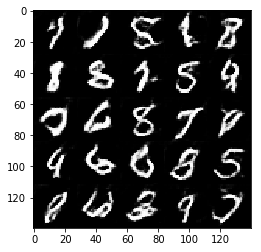

Epoch 1/2.	 Discriminator Loss: 1.6057;  Generator Loss: 0.3511
Epoch 1/2.	 Discriminator Loss: 1.2586;  Generator Loss: 1.3433
Epoch 1/2.	 Discriminator Loss: 1.2270;  Generator Loss: 0.7286
Epoch 1/2.	 Discriminator Loss: 1.2446;  Generator Loss: 0.6217
Epoch 1/2.	 Discriminator Loss: 1.5458;  Generator Loss: 0.3739
Epoch 1/2.	 Discriminator Loss: 1.1220;  Generator Loss: 1.2523
Epoch 1/2.	 Discriminator Loss: 1.5076;  Generator Loss: 0.4203
Epoch 1/2.	 Discriminator Loss: 1.1360;  Generator Loss: 0.7376
Epoch 1/2.	 Discriminator Loss: 1.1171;  Generator Loss: 0.9594
Epoch 1/2.	 Discriminator Loss: 1.1399;  Generator Loss: 0.9056


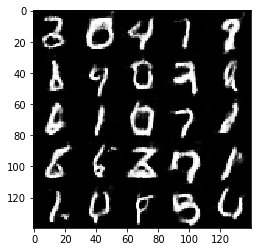

Epoch 1/2.	 Discriminator Loss: 1.2310;  Generator Loss: 1.0510
Epoch 1/2.	 Discriminator Loss: 1.5983;  Generator Loss: 0.3456
Epoch 1/2.	 Discriminator Loss: 1.4356;  Generator Loss: 1.1951
Epoch 2/2.	 Discriminator Loss: 2.0971;  Generator Loss: 2.6587
Epoch 2/2.	 Discriminator Loss: 1.4214;  Generator Loss: 0.5500
Epoch 2/2.	 Discriminator Loss: 1.2757;  Generator Loss: 1.3526
Epoch 2/2.	 Discriminator Loss: 1.2482;  Generator Loss: 0.6411
Epoch 2/2.	 Discriminator Loss: 1.3489;  Generator Loss: 0.5410
Epoch 2/2.	 Discriminator Loss: 1.0550;  Generator Loss: 1.1774
Epoch 2/2.	 Discriminator Loss: 1.3059;  Generator Loss: 0.5247


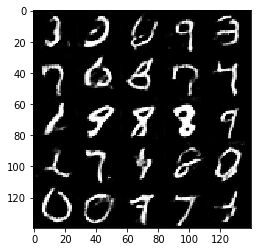

Epoch 2/2.	 Discriminator Loss: 1.4031;  Generator Loss: 0.4632
Epoch 2/2.	 Discriminator Loss: 1.3797;  Generator Loss: 1.8289
Epoch 2/2.	 Discriminator Loss: 1.2763;  Generator Loss: 0.5337
Epoch 2/2.	 Discriminator Loss: 1.0612;  Generator Loss: 1.0279
Epoch 2/2.	 Discriminator Loss: 1.3501;  Generator Loss: 0.5048
Epoch 2/2.	 Discriminator Loss: 1.2817;  Generator Loss: 1.0729
Epoch 2/2.	 Discriminator Loss: 1.1097;  Generator Loss: 1.3779
Epoch 2/2.	 Discriminator Loss: 1.2835;  Generator Loss: 0.5155
Epoch 2/2.	 Discriminator Loss: 1.3043;  Generator Loss: 1.4701
Epoch 2/2.	 Discriminator Loss: 1.2078;  Generator Loss: 1.2698


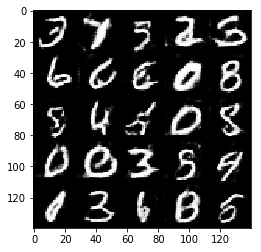

Epoch 2/2.	 Discriminator Loss: 1.1648;  Generator Loss: 1.0353
Epoch 2/2.	 Discriminator Loss: 1.2222;  Generator Loss: 0.8376
Epoch 2/2.	 Discriminator Loss: 1.2934;  Generator Loss: 0.6858
Epoch 2/2.	 Discriminator Loss: 0.9893;  Generator Loss: 0.9633
Epoch 2/2.	 Discriminator Loss: 1.4065;  Generator Loss: 0.4950
Epoch 2/2.	 Discriminator Loss: 1.5065;  Generator Loss: 1.0698
Epoch 2/2.	 Discriminator Loss: 1.2461;  Generator Loss: 0.6232
Epoch 2/2.	 Discriminator Loss: 1.3239;  Generator Loss: 1.9617
Epoch 2/2.	 Discriminator Loss: 1.0838;  Generator Loss: 1.3183
Epoch 2/2.	 Discriminator Loss: 1.5686;  Generator Loss: 0.3555


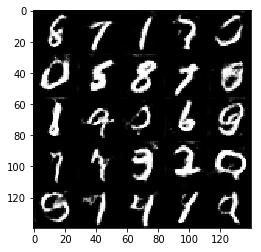

Epoch 2/2.	 Discriminator Loss: 1.4347;  Generator Loss: 0.3921
Epoch 2/2.	 Discriminator Loss: 1.1516;  Generator Loss: 0.8572
Epoch 2/2.	 Discriminator Loss: 1.1391;  Generator Loss: 0.8395
Epoch 2/2.	 Discriminator Loss: 1.2955;  Generator Loss: 0.6223
Epoch 2/2.	 Discriminator Loss: 1.2429;  Generator Loss: 0.6828
Epoch 2/2.	 Discriminator Loss: 1.0536;  Generator Loss: 1.2023
Epoch 2/2.	 Discriminator Loss: 1.1554;  Generator Loss: 1.4138
Epoch 2/2.	 Discriminator Loss: 1.3200;  Generator Loss: 1.0103
Epoch 2/2.	 Discriminator Loss: 1.3027;  Generator Loss: 0.5699
Epoch 2/2.	 Discriminator Loss: 1.5191;  Generator Loss: 1.5503


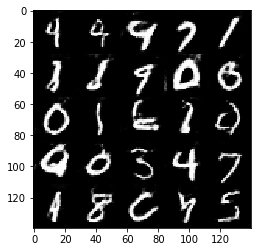

Epoch 2/2.	 Discriminator Loss: 1.1389;  Generator Loss: 0.9998
Epoch 2/2.	 Discriminator Loss: 1.0383;  Generator Loss: 1.4332
Epoch 2/2.	 Discriminator Loss: 1.5982;  Generator Loss: 0.3220
Epoch 2/2.	 Discriminator Loss: 1.2217;  Generator Loss: 0.5576
Epoch 2/2.	 Discriminator Loss: 1.3928;  Generator Loss: 1.2704
Epoch 2/2.	 Discriminator Loss: 1.2597;  Generator Loss: 0.9896
Epoch 2/2.	 Discriminator Loss: 1.9487;  Generator Loss: 0.2304
Epoch 2/2.	 Discriminator Loss: 1.1797;  Generator Loss: 1.0929
Epoch 2/2.	 Discriminator Loss: 1.1292;  Generator Loss: 0.9601
Epoch 2/2.	 Discriminator Loss: 1.1985;  Generator Loss: 1.8576


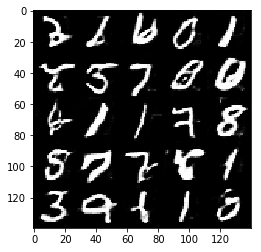

Epoch 2/2.	 Discriminator Loss: 1.3386;  Generator Loss: 0.7131
Epoch 2/2.	 Discriminator Loss: 1.0544;  Generator Loss: 1.4212
Epoch 2/2.	 Discriminator Loss: 1.4903;  Generator Loss: 0.4295
Epoch 2/2.	 Discriminator Loss: 1.4940;  Generator Loss: 0.4988
Epoch 2/2.	 Discriminator Loss: 1.5351;  Generator Loss: 1.3114
Epoch 2/2.	 Discriminator Loss: 1.0102;  Generator Loss: 0.9221
Epoch 2/2.	 Discriminator Loss: 1.2015;  Generator Loss: 0.6367
Epoch 2/2.	 Discriminator Loss: 1.1457;  Generator Loss: 0.9588
Epoch 2/2.	 Discriminator Loss: 1.4695;  Generator Loss: 0.4503
Epoch 2/2.	 Discriminator Loss: 1.5495;  Generator Loss: 0.3762


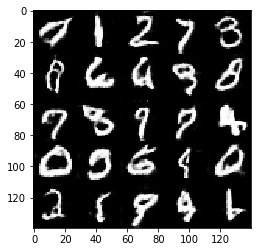

Epoch 2/2.	 Discriminator Loss: 1.4205;  Generator Loss: 0.3920
Epoch 2/2.	 Discriminator Loss: 1.0608;  Generator Loss: 1.6943
Epoch 2/2.	 Discriminator Loss: 1.2219;  Generator Loss: 1.2676
Epoch 2/2.	 Discriminator Loss: 1.1716;  Generator Loss: 1.1446
Epoch 2/2.	 Discriminator Loss: 1.0911;  Generator Loss: 0.8234
Epoch 2/2.	 Discriminator Loss: 1.5472;  Generator Loss: 0.3297
Epoch 2/2.	 Discriminator Loss: 0.9761;  Generator Loss: 0.7583
Epoch 2/2.	 Discriminator Loss: 1.0044;  Generator Loss: 0.9751
Epoch 2/2.	 Discriminator Loss: 0.9888;  Generator Loss: 0.8936
Epoch 2/2.	 Discriminator Loss: 1.2479;  Generator Loss: 0.7468


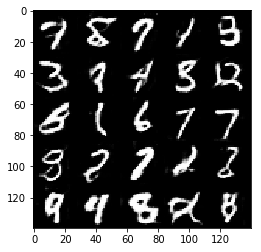

Epoch 2/2.	 Discriminator Loss: 1.1297;  Generator Loss: 1.1072
Epoch 2/2.	 Discriminator Loss: 0.9864;  Generator Loss: 0.6796
Epoch 2/2.	 Discriminator Loss: 1.4603;  Generator Loss: 0.4080
Epoch 2/2.	 Discriminator Loss: 1.4632;  Generator Loss: 0.5268
Epoch 2/2.	 Discriminator Loss: 1.2539;  Generator Loss: 0.9239
Epoch 2/2.	 Discriminator Loss: 0.9504;  Generator Loss: 1.4599
Epoch 2/2.	 Discriminator Loss: 1.0040;  Generator Loss: 1.2358
Epoch 2/2.	 Discriminator Loss: 1.6042;  Generator Loss: 0.3237
Epoch 2/2.	 Discriminator Loss: 1.0018;  Generator Loss: 0.9562
Epoch 2/2.	 Discriminator Loss: 1.1054;  Generator Loss: 0.6885


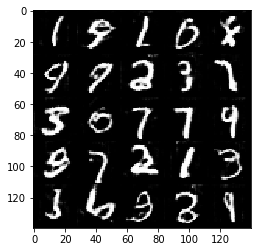

Epoch 2/2.	 Discriminator Loss: 1.2023;  Generator Loss: 0.7485
Epoch 2/2.	 Discriminator Loss: 1.4652;  Generator Loss: 0.4090
Epoch 2/2.	 Discriminator Loss: 1.5839;  Generator Loss: 2.1304
Epoch 2/2.	 Discriminator Loss: 1.1873;  Generator Loss: 0.7969
Epoch 2/2.	 Discriminator Loss: 1.2060;  Generator Loss: 0.9567
Epoch 2/2.	 Discriminator Loss: 1.4359;  Generator Loss: 0.3985
Epoch 2/2.	 Discriminator Loss: 1.2202;  Generator Loss: 1.8283
Epoch 2/2.	 Discriminator Loss: 1.1102;  Generator Loss: 0.6798
Epoch 2/2.	 Discriminator Loss: 1.6291;  Generator Loss: 0.3976
Epoch 2/2.	 Discriminator Loss: 1.6375;  Generator Loss: 0.4098


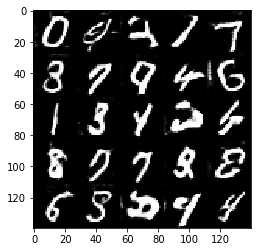

Epoch 2/2.	 Discriminator Loss: 0.8650;  Generator Loss: 1.8963
Epoch 2/2.	 Discriminator Loss: 1.4985;  Generator Loss: 2.6056
Epoch 2/2.	 Discriminator Loss: 1.1913;  Generator Loss: 1.6277
Epoch 2/2.	 Discriminator Loss: 1.1766;  Generator Loss: 1.1355
Epoch 2/2.	 Discriminator Loss: 1.1448;  Generator Loss: 1.0732
Epoch 2/2.	 Discriminator Loss: 1.4426;  Generator Loss: 0.4709
Epoch 2/2.	 Discriminator Loss: 0.9606;  Generator Loss: 1.3753


In [28]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1.	 Discriminator Loss: 3.2145;  Generator Loss: 0.6644
Epoch 1/1.	 Discriminator Loss: 2.1381;  Generator Loss: 0.9312
Epoch 1/1.	 Discriminator Loss: 1.1793;  Generator Loss: 1.2783
Epoch 1/1.	 Discriminator Loss: 0.4695;  Generator Loss: 1.9867
Epoch 1/1.	 Discriminator Loss: 0.7298;  Generator Loss: 1.0462
Epoch 1/1.	 Discriminator Loss: 1.1114;  Generator Loss: 0.6227
Epoch 1/1.	 Discriminator Loss: 1.7799;  Generator Loss: 0.4811
Epoch 1/1.	 Discriminator Loss: 0.8644;  Generator Loss: 1.0362
Epoch 1/1.	 Discriminator Loss: 0.9895;  Generator Loss: 1.2018
Epoch 1/1.	 Discriminator Loss: 2.3739;  Generator Loss: 1.1328


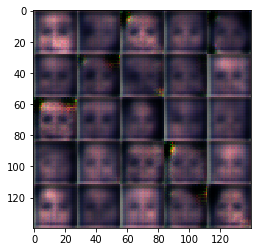

Epoch 1/1.	 Discriminator Loss: 1.5645;  Generator Loss: 0.5097
Epoch 1/1.	 Discriminator Loss: 1.9082;  Generator Loss: 0.5399
Epoch 1/1.	 Discriminator Loss: 1.4382;  Generator Loss: 0.7071
Epoch 1/1.	 Discriminator Loss: 1.4653;  Generator Loss: 0.4796
Epoch 1/1.	 Discriminator Loss: 1.7131;  Generator Loss: 0.3685
Epoch 1/1.	 Discriminator Loss: 1.3592;  Generator Loss: 0.8422
Epoch 1/1.	 Discriminator Loss: 1.2562;  Generator Loss: 0.8162
Epoch 1/1.	 Discriminator Loss: 1.6789;  Generator Loss: 1.3567
Epoch 1/1.	 Discriminator Loss: 1.9759;  Generator Loss: 1.2512
Epoch 1/1.	 Discriminator Loss: 1.2066;  Generator Loss: 1.0120


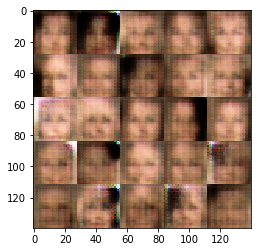

Epoch 1/1.	 Discriminator Loss: 1.3658;  Generator Loss: 0.5725
Epoch 1/1.	 Discriminator Loss: 1.6963;  Generator Loss: 0.3781
Epoch 1/1.	 Discriminator Loss: 1.4822;  Generator Loss: 0.5604
Epoch 1/1.	 Discriminator Loss: 1.0353;  Generator Loss: 0.8004
Epoch 1/1.	 Discriminator Loss: 1.8263;  Generator Loss: 0.3158
Epoch 1/1.	 Discriminator Loss: 1.8173;  Generator Loss: 0.6782
Epoch 1/1.	 Discriminator Loss: 1.2892;  Generator Loss: 0.8575
Epoch 1/1.	 Discriminator Loss: 1.5032;  Generator Loss: 0.9039
Epoch 1/1.	 Discriminator Loss: 1.1030;  Generator Loss: 0.7229
Epoch 1/1.	 Discriminator Loss: 1.4941;  Generator Loss: 0.9324


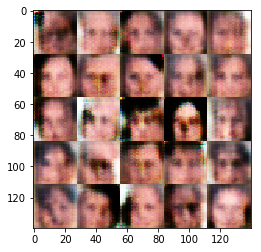

Epoch 1/1.	 Discriminator Loss: 1.5284;  Generator Loss: 0.5997
Epoch 1/1.	 Discriminator Loss: 1.3152;  Generator Loss: 1.0169
Epoch 1/1.	 Discriminator Loss: 1.5811;  Generator Loss: 1.0613
Epoch 1/1.	 Discriminator Loss: 1.1551;  Generator Loss: 0.9054
Epoch 1/1.	 Discriminator Loss: 1.3641;  Generator Loss: 0.7915
Epoch 1/1.	 Discriminator Loss: 1.6394;  Generator Loss: 0.4321
Epoch 1/1.	 Discriminator Loss: 1.5133;  Generator Loss: 1.0961
Epoch 1/1.	 Discriminator Loss: 1.3654;  Generator Loss: 0.7008
Epoch 1/1.	 Discriminator Loss: 1.3345;  Generator Loss: 0.6599
Epoch 1/1.	 Discriminator Loss: 1.3457;  Generator Loss: 0.6282


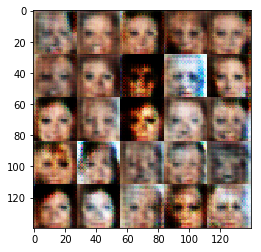

Epoch 1/1.	 Discriminator Loss: 1.3458;  Generator Loss: 0.6366
Epoch 1/1.	 Discriminator Loss: 1.2635;  Generator Loss: 0.9286
Epoch 1/1.	 Discriminator Loss: 1.8136;  Generator Loss: 0.5342
Epoch 1/1.	 Discriminator Loss: 1.3359;  Generator Loss: 0.7787
Epoch 1/1.	 Discriminator Loss: 1.4063;  Generator Loss: 0.5208
Epoch 1/1.	 Discriminator Loss: 1.5177;  Generator Loss: 0.5010
Epoch 1/1.	 Discriminator Loss: 1.5148;  Generator Loss: 0.7416
Epoch 1/1.	 Discriminator Loss: 1.2200;  Generator Loss: 0.8930
Epoch 1/1.	 Discriminator Loss: 1.4588;  Generator Loss: 0.7554
Epoch 1/1.	 Discriminator Loss: 1.2818;  Generator Loss: 0.7985


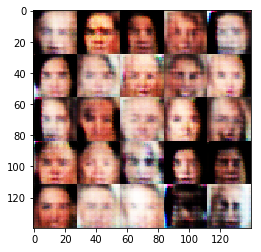

Epoch 1/1.	 Discriminator Loss: 1.6303;  Generator Loss: 0.4425
Epoch 1/1.	 Discriminator Loss: 1.3247;  Generator Loss: 0.7812
Epoch 1/1.	 Discriminator Loss: 1.7097;  Generator Loss: 0.3995
Epoch 1/1.	 Discriminator Loss: 1.7277;  Generator Loss: 1.5488
Epoch 1/1.	 Discriminator Loss: 1.7821;  Generator Loss: 0.4430
Epoch 1/1.	 Discriminator Loss: 1.3228;  Generator Loss: 0.8043
Epoch 1/1.	 Discriminator Loss: 1.3829;  Generator Loss: 0.5467
Epoch 1/1.	 Discriminator Loss: 1.4814;  Generator Loss: 0.8324
Epoch 1/1.	 Discriminator Loss: 1.4900;  Generator Loss: 0.6281
Epoch 1/1.	 Discriminator Loss: 1.6992;  Generator Loss: 0.7436


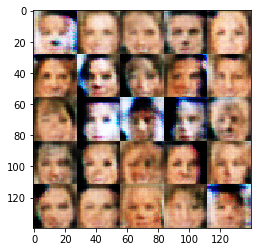

Epoch 1/1.	 Discriminator Loss: 1.4351;  Generator Loss: 0.5762
Epoch 1/1.	 Discriminator Loss: 1.3110;  Generator Loss: 0.8664
Epoch 1/1.	 Discriminator Loss: 1.5090;  Generator Loss: 0.8263
Epoch 1/1.	 Discriminator Loss: 1.1315;  Generator Loss: 0.9222
Epoch 1/1.	 Discriminator Loss: 1.6970;  Generator Loss: 0.4653
Epoch 1/1.	 Discriminator Loss: 1.4666;  Generator Loss: 0.6737
Epoch 1/1.	 Discriminator Loss: 1.5150;  Generator Loss: 0.7665
Epoch 1/1.	 Discriminator Loss: 1.3843;  Generator Loss: 0.6251
Epoch 1/1.	 Discriminator Loss: 1.5636;  Generator Loss: 0.6043
Epoch 1/1.	 Discriminator Loss: 1.4880;  Generator Loss: 0.6231


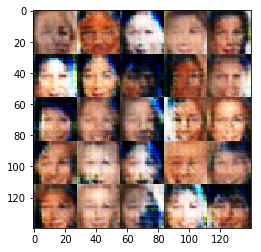

Epoch 1/1.	 Discriminator Loss: 1.9045;  Generator Loss: 1.0429
Epoch 1/1.	 Discriminator Loss: 1.5422;  Generator Loss: 0.6839
Epoch 1/1.	 Discriminator Loss: 1.5388;  Generator Loss: 0.8411
Epoch 1/1.	 Discriminator Loss: 1.3409;  Generator Loss: 0.6926
Epoch 1/1.	 Discriminator Loss: 1.3876;  Generator Loss: 0.7842
Epoch 1/1.	 Discriminator Loss: 1.7610;  Generator Loss: 0.3127
Epoch 1/1.	 Discriminator Loss: 1.4004;  Generator Loss: 0.7239
Epoch 1/1.	 Discriminator Loss: 1.2269;  Generator Loss: 0.5932
Epoch 1/1.	 Discriminator Loss: 1.4591;  Generator Loss: 0.5815
Epoch 1/1.	 Discriminator Loss: 1.3241;  Generator Loss: 0.4886


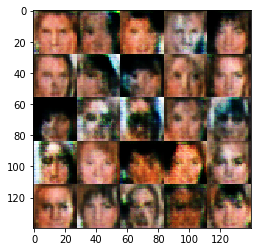

Epoch 1/1.	 Discriminator Loss: 1.4908;  Generator Loss: 0.6611
Epoch 1/1.	 Discriminator Loss: 1.6247;  Generator Loss: 0.3664
Epoch 1/1.	 Discriminator Loss: 1.4038;  Generator Loss: 0.6402
Epoch 1/1.	 Discriminator Loss: 1.5565;  Generator Loss: 0.6959
Epoch 1/1.	 Discriminator Loss: 1.5476;  Generator Loss: 0.7417
Epoch 1/1.	 Discriminator Loss: 1.4234;  Generator Loss: 0.7320
Epoch 1/1.	 Discriminator Loss: 1.4721;  Generator Loss: 0.8237
Epoch 1/1.	 Discriminator Loss: 1.5012;  Generator Loss: 0.6238
Epoch 1/1.	 Discriminator Loss: 1.5969;  Generator Loss: 0.7091
Epoch 1/1.	 Discriminator Loss: 1.2642;  Generator Loss: 0.7453


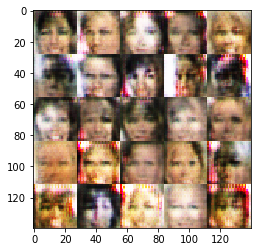

Epoch 1/1.	 Discriminator Loss: 1.3373;  Generator Loss: 0.8307
Epoch 1/1.	 Discriminator Loss: 1.3983;  Generator Loss: 0.6762
Epoch 1/1.	 Discriminator Loss: 1.4832;  Generator Loss: 0.6473
Epoch 1/1.	 Discriminator Loss: 1.4637;  Generator Loss: 0.6825
Epoch 1/1.	 Discriminator Loss: 1.4702;  Generator Loss: 0.7816
Epoch 1/1.	 Discriminator Loss: 1.4218;  Generator Loss: 0.6635
Epoch 1/1.	 Discriminator Loss: 1.0983;  Generator Loss: 0.9334
Epoch 1/1.	 Discriminator Loss: 1.2709;  Generator Loss: 0.5768
Epoch 1/1.	 Discriminator Loss: 1.8473;  Generator Loss: 0.5190
Epoch 1/1.	 Discriminator Loss: 1.4605;  Generator Loss: 0.5499


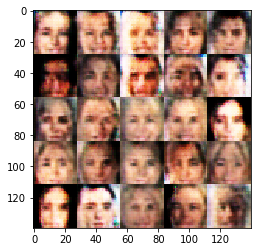

Epoch 1/1.	 Discriminator Loss: 1.1734;  Generator Loss: 0.7634
Epoch 1/1.	 Discriminator Loss: 1.5277;  Generator Loss: 0.6675
Epoch 1/1.	 Discriminator Loss: 1.4259;  Generator Loss: 0.6694
Epoch 1/1.	 Discriminator Loss: 1.7019;  Generator Loss: 0.3596
Epoch 1/1.	 Discriminator Loss: 1.5035;  Generator Loss: 0.6836
Epoch 1/1.	 Discriminator Loss: 1.4064;  Generator Loss: 0.8459
Epoch 1/1.	 Discriminator Loss: 1.3614;  Generator Loss: 0.8610
Epoch 1/1.	 Discriminator Loss: 1.5703;  Generator Loss: 0.8826
Epoch 1/1.	 Discriminator Loss: 1.4276;  Generator Loss: 0.7194
Epoch 1/1.	 Discriminator Loss: 1.6703;  Generator Loss: 0.6847


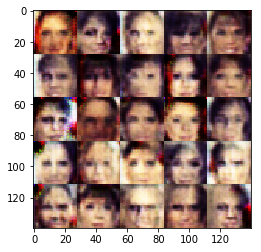

Epoch 1/1.	 Discriminator Loss: 1.3789;  Generator Loss: 0.8155
Epoch 1/1.	 Discriminator Loss: 1.4176;  Generator Loss: 0.7308
Epoch 1/1.	 Discriminator Loss: 1.3153;  Generator Loss: 0.8879
Epoch 1/1.	 Discriminator Loss: 1.3899;  Generator Loss: 1.0137
Epoch 1/1.	 Discriminator Loss: 1.3489;  Generator Loss: 0.6279
Epoch 1/1.	 Discriminator Loss: 1.5122;  Generator Loss: 0.5315
Epoch 1/1.	 Discriminator Loss: 1.4217;  Generator Loss: 0.8182
Epoch 1/1.	 Discriminator Loss: 1.5291;  Generator Loss: 0.7305
Epoch 1/1.	 Discriminator Loss: 1.5843;  Generator Loss: 1.1341
Epoch 1/1.	 Discriminator Loss: 1.4061;  Generator Loss: 0.6253


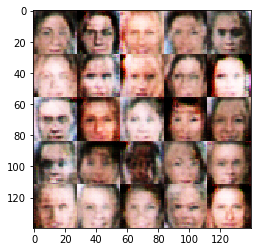

Epoch 1/1.	 Discriminator Loss: 1.2455;  Generator Loss: 0.6409
Epoch 1/1.	 Discriminator Loss: 1.3378;  Generator Loss: 0.7790
Epoch 1/1.	 Discriminator Loss: 1.4255;  Generator Loss: 0.8279
Epoch 1/1.	 Discriminator Loss: 1.3898;  Generator Loss: 0.7013
Epoch 1/1.	 Discriminator Loss: 1.4444;  Generator Loss: 0.8376
Epoch 1/1.	 Discriminator Loss: 1.3728;  Generator Loss: 0.6475
Epoch 1/1.	 Discriminator Loss: 1.5410;  Generator Loss: 0.9884
Epoch 1/1.	 Discriminator Loss: 1.3246;  Generator Loss: 0.7477
Epoch 1/1.	 Discriminator Loss: 1.2669;  Generator Loss: 0.7651
Epoch 1/1.	 Discriminator Loss: 1.3862;  Generator Loss: 0.5829


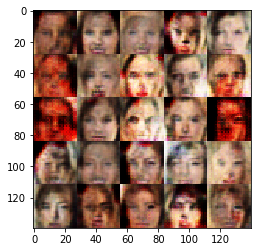

Epoch 1/1.	 Discriminator Loss: 1.3615;  Generator Loss: 0.5945
Epoch 1/1.	 Discriminator Loss: 1.4171;  Generator Loss: 0.6491
Epoch 1/1.	 Discriminator Loss: 1.4548;  Generator Loss: 0.8184
Epoch 1/1.	 Discriminator Loss: 1.4596;  Generator Loss: 0.6035
Epoch 1/1.	 Discriminator Loss: 1.3940;  Generator Loss: 0.9311
Epoch 1/1.	 Discriminator Loss: 1.3762;  Generator Loss: 0.6233
Epoch 1/1.	 Discriminator Loss: 1.3681;  Generator Loss: 0.5127
Epoch 1/1.	 Discriminator Loss: 1.7351;  Generator Loss: 0.4494
Epoch 1/1.	 Discriminator Loss: 1.5436;  Generator Loss: 0.4900
Epoch 1/1.	 Discriminator Loss: 1.4489;  Generator Loss: 0.7902


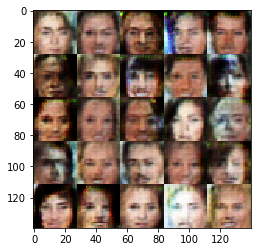

Epoch 1/1.	 Discriminator Loss: 1.4520;  Generator Loss: 0.8446
Epoch 1/1.	 Discriminator Loss: 1.3480;  Generator Loss: 0.7333
Epoch 1/1.	 Discriminator Loss: 1.2312;  Generator Loss: 0.7536
Epoch 1/1.	 Discriminator Loss: 1.5245;  Generator Loss: 0.9838
Epoch 1/1.	 Discriminator Loss: 1.3876;  Generator Loss: 0.5910
Epoch 1/1.	 Discriminator Loss: 1.3692;  Generator Loss: 0.6734
Epoch 1/1.	 Discriminator Loss: 1.3507;  Generator Loss: 0.7486
Epoch 1/1.	 Discriminator Loss: 1.4641;  Generator Loss: 0.7165
Epoch 1/1.	 Discriminator Loss: 1.3412;  Generator Loss: 0.5998
Epoch 1/1.	 Discriminator Loss: 1.3469;  Generator Loss: 0.7236


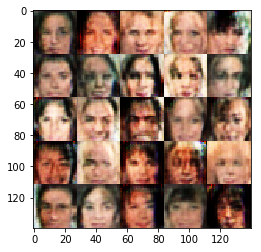

Epoch 1/1.	 Discriminator Loss: 1.3739;  Generator Loss: 0.6549
Epoch 1/1.	 Discriminator Loss: 1.3320;  Generator Loss: 0.7812
Epoch 1/1.	 Discriminator Loss: 1.4643;  Generator Loss: 0.6399
Epoch 1/1.	 Discriminator Loss: 1.4168;  Generator Loss: 0.5349
Epoch 1/1.	 Discriminator Loss: 1.4822;  Generator Loss: 0.6894
Epoch 1/1.	 Discriminator Loss: 1.5354;  Generator Loss: 0.7520
Epoch 1/1.	 Discriminator Loss: 1.2322;  Generator Loss: 0.7827
Epoch 1/1.	 Discriminator Loss: 1.4301;  Generator Loss: 0.6428
Epoch 1/1.	 Discriminator Loss: 1.3822;  Generator Loss: 0.8531
Epoch 1/1.	 Discriminator Loss: 1.3831;  Generator Loss: 0.6704


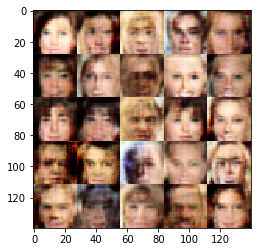

Epoch 1/1.	 Discriminator Loss: 1.3395;  Generator Loss: 0.6211
Epoch 1/1.	 Discriminator Loss: 1.3767;  Generator Loss: 0.5661
Epoch 1/1.	 Discriminator Loss: 1.3866;  Generator Loss: 0.8611
Epoch 1/1.	 Discriminator Loss: 1.3021;  Generator Loss: 0.6607
Epoch 1/1.	 Discriminator Loss: 1.4719;  Generator Loss: 1.1333
Epoch 1/1.	 Discriminator Loss: 1.4117;  Generator Loss: 0.7701
Epoch 1/1.	 Discriminator Loss: 1.4847;  Generator Loss: 0.4529
Epoch 1/1.	 Discriminator Loss: 1.3954;  Generator Loss: 0.8282
Epoch 1/1.	 Discriminator Loss: 1.3474;  Generator Loss: 0.5202
Epoch 1/1.	 Discriminator Loss: 1.2880;  Generator Loss: 0.6690


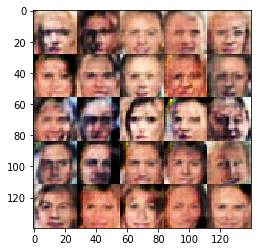

Epoch 1/1.	 Discriminator Loss: 1.4972;  Generator Loss: 0.6625
Epoch 1/1.	 Discriminator Loss: 1.4672;  Generator Loss: 0.7225
Epoch 1/1.	 Discriminator Loss: 1.3838;  Generator Loss: 0.5392
Epoch 1/1.	 Discriminator Loss: 1.4598;  Generator Loss: 0.7268
Epoch 1/1.	 Discriminator Loss: 1.2695;  Generator Loss: 0.7125
Epoch 1/1.	 Discriminator Loss: 1.5492;  Generator Loss: 0.5380
Epoch 1/1.	 Discriminator Loss: 1.3704;  Generator Loss: 0.6508
Epoch 1/1.	 Discriminator Loss: 1.4928;  Generator Loss: 0.9279
Epoch 1/1.	 Discriminator Loss: 1.4147;  Generator Loss: 0.6777
Epoch 1/1.	 Discriminator Loss: 1.2951;  Generator Loss: 0.7481


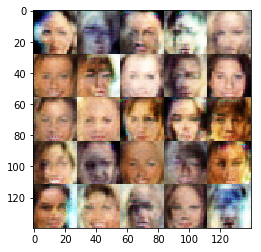

Epoch 1/1.	 Discriminator Loss: 1.6104;  Generator Loss: 0.5972
Epoch 1/1.	 Discriminator Loss: 1.3724;  Generator Loss: 0.7736
Epoch 1/1.	 Discriminator Loss: 1.2998;  Generator Loss: 0.6284
Epoch 1/1.	 Discriminator Loss: 1.3827;  Generator Loss: 0.7198
Epoch 1/1.	 Discriminator Loss: 1.5373;  Generator Loss: 0.6405
Epoch 1/1.	 Discriminator Loss: 1.4224;  Generator Loss: 0.8355
Epoch 1/1.	 Discriminator Loss: 1.4212;  Generator Loss: 0.7927
Epoch 1/1.	 Discriminator Loss: 1.3849;  Generator Loss: 0.7179
Epoch 1/1.	 Discriminator Loss: 1.6739;  Generator Loss: 0.8673
Epoch 1/1.	 Discriminator Loss: 1.3550;  Generator Loss: 0.6372


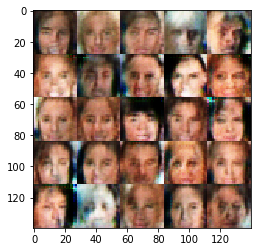

Epoch 1/1.	 Discriminator Loss: 1.2923;  Generator Loss: 0.6062
Epoch 1/1.	 Discriminator Loss: 1.4196;  Generator Loss: 0.9541
Epoch 1/1.	 Discriminator Loss: 1.3894;  Generator Loss: 0.5133
Epoch 1/1.	 Discriminator Loss: 1.4912;  Generator Loss: 0.9143
Epoch 1/1.	 Discriminator Loss: 1.3410;  Generator Loss: 0.7918
Epoch 1/1.	 Discriminator Loss: 1.2273;  Generator Loss: 1.1300
Epoch 1/1.	 Discriminator Loss: 1.8037;  Generator Loss: 0.3373
Epoch 1/1.	 Discriminator Loss: 1.3370;  Generator Loss: 0.6953
Epoch 1/1.	 Discriminator Loss: 1.3886;  Generator Loss: 0.5864
Epoch 1/1.	 Discriminator Loss: 1.3612;  Generator Loss: 0.6042


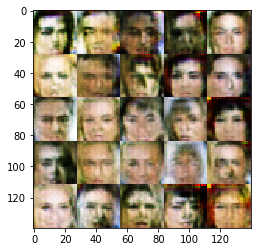

Epoch 1/1.	 Discriminator Loss: 1.6705;  Generator Loss: 0.3562
Epoch 1/1.	 Discriminator Loss: 1.5443;  Generator Loss: 0.6289
Epoch 1/1.	 Discriminator Loss: 1.3820;  Generator Loss: 0.9124
Epoch 1/1.	 Discriminator Loss: 1.3940;  Generator Loss: 0.8450
Epoch 1/1.	 Discriminator Loss: 1.4853;  Generator Loss: 0.5517
Epoch 1/1.	 Discriminator Loss: 1.2284;  Generator Loss: 0.6056
Epoch 1/1.	 Discriminator Loss: 1.5297;  Generator Loss: 1.1671
Epoch 1/1.	 Discriminator Loss: 1.6107;  Generator Loss: 0.6962
Epoch 1/1.	 Discriminator Loss: 1.2246;  Generator Loss: 0.6249
Epoch 1/1.	 Discriminator Loss: 1.4417;  Generator Loss: 0.6395


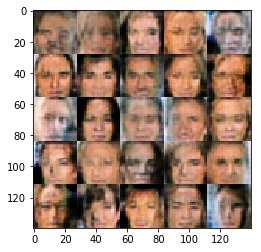

Epoch 1/1.	 Discriminator Loss: 1.2496;  Generator Loss: 0.8572
Epoch 1/1.	 Discriminator Loss: 1.4107;  Generator Loss: 0.6782
Epoch 1/1.	 Discriminator Loss: 1.6959;  Generator Loss: 0.8328
Epoch 1/1.	 Discriminator Loss: 1.3861;  Generator Loss: 0.8751
Epoch 1/1.	 Discriminator Loss: 1.4750;  Generator Loss: 0.7977
Epoch 1/1.	 Discriminator Loss: 1.3603;  Generator Loss: 0.7183
Epoch 1/1.	 Discriminator Loss: 1.3388;  Generator Loss: 0.7943
Epoch 1/1.	 Discriminator Loss: 1.3139;  Generator Loss: 0.6794
Epoch 1/1.	 Discriminator Loss: 1.3721;  Generator Loss: 0.7208
Epoch 1/1.	 Discriminator Loss: 1.2228;  Generator Loss: 0.6888


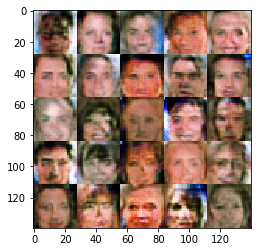

Epoch 1/1.	 Discriminator Loss: 1.4137;  Generator Loss: 0.7553
Epoch 1/1.	 Discriminator Loss: 1.3218;  Generator Loss: 0.6854
Epoch 1/1.	 Discriminator Loss: 1.3287;  Generator Loss: 0.6314
Epoch 1/1.	 Discriminator Loss: 1.3400;  Generator Loss: 0.5780
Epoch 1/1.	 Discriminator Loss: 1.4493;  Generator Loss: 0.6434
Epoch 1/1.	 Discriminator Loss: 1.4492;  Generator Loss: 1.0081
Epoch 1/1.	 Discriminator Loss: 1.4237;  Generator Loss: 0.6334
Epoch 1/1.	 Discriminator Loss: 1.2580;  Generator Loss: 0.5995
Epoch 1/1.	 Discriminator Loss: 1.2370;  Generator Loss: 0.7487
Epoch 1/1.	 Discriminator Loss: 1.2778;  Generator Loss: 0.8077


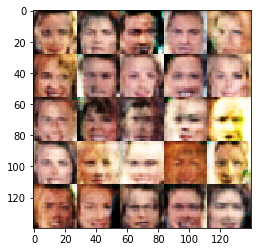

Epoch 1/1.	 Discriminator Loss: 1.4612;  Generator Loss: 0.6021
Epoch 1/1.	 Discriminator Loss: 0.8301;  Generator Loss: 0.9550
Epoch 1/1.	 Discriminator Loss: 1.1777;  Generator Loss: 0.6889
Epoch 1/1.	 Discriminator Loss: 2.0682;  Generator Loss: 0.6984
Epoch 1/1.	 Discriminator Loss: 1.4267;  Generator Loss: 0.6357
Epoch 1/1.	 Discriminator Loss: 1.5797;  Generator Loss: 1.2120
Epoch 1/1.	 Discriminator Loss: 1.4846;  Generator Loss: 0.7802
Epoch 1/1.	 Discriminator Loss: 1.3732;  Generator Loss: 0.7658
Epoch 1/1.	 Discriminator Loss: 1.4160;  Generator Loss: 0.7616
Epoch 1/1.	 Discriminator Loss: 1.3262;  Generator Loss: 0.9141


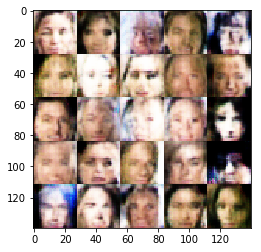

Epoch 1/1.	 Discriminator Loss: 1.2785;  Generator Loss: 0.6592
Epoch 1/1.	 Discriminator Loss: 1.3765;  Generator Loss: 0.5712
Epoch 1/1.	 Discriminator Loss: 1.4175;  Generator Loss: 0.6815
Epoch 1/1.	 Discriminator Loss: 1.3354;  Generator Loss: 0.6887
Epoch 1/1.	 Discriminator Loss: 1.4326;  Generator Loss: 0.6590
Epoch 1/1.	 Discriminator Loss: 1.3326;  Generator Loss: 0.7397
Epoch 1/1.	 Discriminator Loss: 1.4084;  Generator Loss: 0.7592
Epoch 1/1.	 Discriminator Loss: 1.3885;  Generator Loss: 0.5728
Epoch 1/1.	 Discriminator Loss: 1.4056;  Generator Loss: 0.9048
Epoch 1/1.	 Discriminator Loss: 1.3999;  Generator Loss: 0.4695


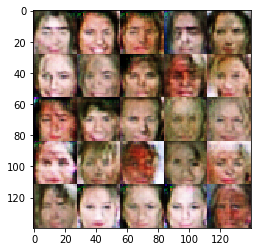

Epoch 1/1.	 Discriminator Loss: 1.3222;  Generator Loss: 0.8099
Epoch 1/1.	 Discriminator Loss: 1.3380;  Generator Loss: 0.7444
Epoch 1/1.	 Discriminator Loss: 1.4998;  Generator Loss: 0.4823
Epoch 1/1.	 Discriminator Loss: 1.3578;  Generator Loss: 0.7182
Epoch 1/1.	 Discriminator Loss: 1.3933;  Generator Loss: 0.6282
Epoch 1/1.	 Discriminator Loss: 1.2870;  Generator Loss: 0.7762
Epoch 1/1.	 Discriminator Loss: 1.3695;  Generator Loss: 0.7629
Epoch 1/1.	 Discriminator Loss: 1.3538;  Generator Loss: 0.6902
Epoch 1/1.	 Discriminator Loss: 1.3090;  Generator Loss: 0.7717
Epoch 1/1.	 Discriminator Loss: 1.4055;  Generator Loss: 0.5741


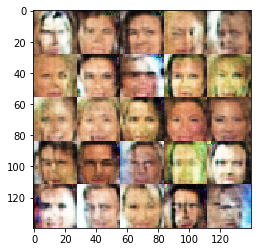

Epoch 1/1.	 Discriminator Loss: 1.4152;  Generator Loss: 0.6337
Epoch 1/1.	 Discriminator Loss: 1.3620;  Generator Loss: 0.6791
Epoch 1/1.	 Discriminator Loss: 1.4018;  Generator Loss: 0.8666
Epoch 1/1.	 Discriminator Loss: 1.4850;  Generator Loss: 0.5042
Epoch 1/1.	 Discriminator Loss: 1.3168;  Generator Loss: 0.7039
Epoch 1/1.	 Discriminator Loss: 1.4209;  Generator Loss: 0.5853
Epoch 1/1.	 Discriminator Loss: 1.4382;  Generator Loss: 0.6896
Epoch 1/1.	 Discriminator Loss: 1.3569;  Generator Loss: 0.6224
Epoch 1/1.	 Discriminator Loss: 1.4450;  Generator Loss: 0.6643
Epoch 1/1.	 Discriminator Loss: 1.3557;  Generator Loss: 0.7086


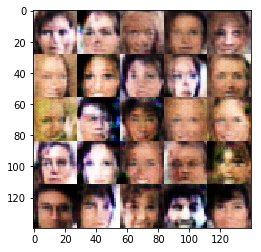

Epoch 1/1.	 Discriminator Loss: 1.3565;  Generator Loss: 0.6529
Epoch 1/1.	 Discriminator Loss: 1.3495;  Generator Loss: 0.7684
Epoch 1/1.	 Discriminator Loss: 1.2935;  Generator Loss: 0.5182
Epoch 1/1.	 Discriminator Loss: 1.3691;  Generator Loss: 0.8676
Epoch 1/1.	 Discriminator Loss: 1.4242;  Generator Loss: 0.6511
Epoch 1/1.	 Discriminator Loss: 1.4019;  Generator Loss: 0.6187
Epoch 1/1.	 Discriminator Loss: 1.4083;  Generator Loss: 0.5847
Epoch 1/1.	 Discriminator Loss: 1.3924;  Generator Loss: 0.6945
Epoch 1/1.	 Discriminator Loss: 1.3046;  Generator Loss: 0.7000
Epoch 1/1.	 Discriminator Loss: 1.3264;  Generator Loss: 0.6495


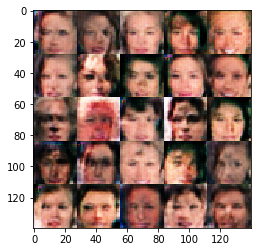

Epoch 1/1.	 Discriminator Loss: 1.2675;  Generator Loss: 0.6277
Epoch 1/1.	 Discriminator Loss: 1.5167;  Generator Loss: 0.8384
Epoch 1/1.	 Discriminator Loss: 1.4585;  Generator Loss: 0.5836
Epoch 1/1.	 Discriminator Loss: 1.4101;  Generator Loss: 0.6431
Epoch 1/1.	 Discriminator Loss: 1.2996;  Generator Loss: 0.6928
Epoch 1/1.	 Discriminator Loss: 1.3672;  Generator Loss: 0.5803
Epoch 1/1.	 Discriminator Loss: 1.3110;  Generator Loss: 0.5980
Epoch 1/1.	 Discriminator Loss: 1.3867;  Generator Loss: 0.6762
Epoch 1/1.	 Discriminator Loss: 1.3215;  Generator Loss: 0.6827
Epoch 1/1.	 Discriminator Loss: 1.3050;  Generator Loss: 0.6475


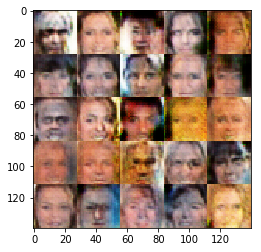

Epoch 1/1.	 Discriminator Loss: 1.3433;  Generator Loss: 0.7407
Epoch 1/1.	 Discriminator Loss: 1.4361;  Generator Loss: 0.7930
Epoch 1/1.	 Discriminator Loss: 1.2019;  Generator Loss: 0.7059
Epoch 1/1.	 Discriminator Loss: 1.3653;  Generator Loss: 0.7143
Epoch 1/1.	 Discriminator Loss: 1.3209;  Generator Loss: 0.6201
Epoch 1/1.	 Discriminator Loss: 1.3181;  Generator Loss: 0.5918
Epoch 1/1.	 Discriminator Loss: 1.4369;  Generator Loss: 0.6678
Epoch 1/1.	 Discriminator Loss: 1.3854;  Generator Loss: 0.7749
Epoch 1/1.	 Discriminator Loss: 1.4928;  Generator Loss: 0.7360
Epoch 1/1.	 Discriminator Loss: 1.3682;  Generator Loss: 0.6871


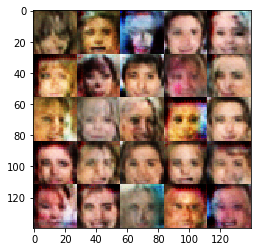

Epoch 1/1.	 Discriminator Loss: 1.2923;  Generator Loss: 0.5644
Epoch 1/1.	 Discriminator Loss: 1.3308;  Generator Loss: 0.7078
Epoch 1/1.	 Discriminator Loss: 1.4292;  Generator Loss: 0.7341
Epoch 1/1.	 Discriminator Loss: 1.4045;  Generator Loss: 0.7684
Epoch 1/1.	 Discriminator Loss: 1.3889;  Generator Loss: 0.7247
Epoch 1/1.	 Discriminator Loss: 1.4048;  Generator Loss: 0.7051
Epoch 1/1.	 Discriminator Loss: 1.4660;  Generator Loss: 0.6448
Epoch 1/1.	 Discriminator Loss: 1.3009;  Generator Loss: 0.7435
Epoch 1/1.	 Discriminator Loss: 1.4131;  Generator Loss: 0.6693
Epoch 1/1.	 Discriminator Loss: 1.3690;  Generator Loss: 0.7231


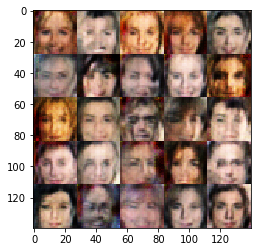

Epoch 1/1.	 Discriminator Loss: 1.3519;  Generator Loss: 0.8407
Epoch 1/1.	 Discriminator Loss: 1.3540;  Generator Loss: 0.5850
Epoch 1/1.	 Discriminator Loss: 1.4719;  Generator Loss: 0.6844
Epoch 1/1.	 Discriminator Loss: 1.3966;  Generator Loss: 0.7418
Epoch 1/1.	 Discriminator Loss: 1.3275;  Generator Loss: 0.6217
Epoch 1/1.	 Discriminator Loss: 1.3620;  Generator Loss: 0.6963


In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.